In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from math import sqrt
import numpy as np
import optuna
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt


data= pd.read_csv('1dataset.csv')

# Создадим таблицу для вывода
А также функцию, добавляющую метрики в датафрейм

In [2]:
table_all_metrics = pd.DataFrame(columns=['Model','MAE','MSE','RMSE','MAPE','R^2'])

In [3]:
def add_err_to_dataframe(dataframe, model_name, dict_errors):
    new_row = {'Model': model_name}
    
    # Добавляем ошибки в строку
    for error, value in dict_errors.items():
        new_row[error] = value
    
    # Добавляем строку в DataFrame
    dataframe.loc[len(dataframe)] = new_row

# Линейная регрессия

In [4]:
# Разделение на признаки и целевую переменную
y = data["price"]
X = data.drop(["price"], axis=1)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
lr = LinearRegression().fit(X_train, y_train)

# Предсказание
y_pred = lr.predict(X_test)


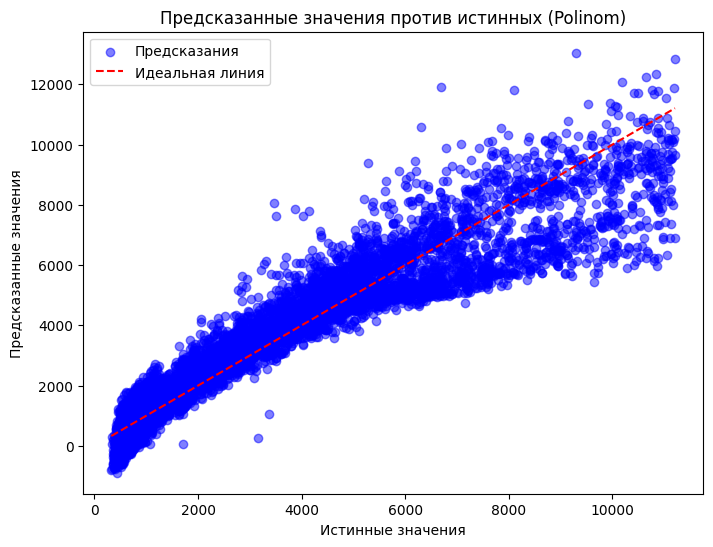

In [38]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

Напишем функции, которые добавят метрики в таблицу

In [5]:
def dict_errors(y_pred, y_test):
  return {'MAE': mean_absolute_error(y_test, y_pred),
          'MSE': mean_squared_error(y_test, y_pred),
          'RMSE': sqrt(mean_squared_error(y_test, y_pred)),
          'MAPE': sqrt(mean_absolute_percentage_error(y_test, y_pred)),
          'R^2': r2_score(y_test, y_pred)}
  
def add_err_to_dataframe(dataframe, model_name, dict_errors):
    new_row = {'Model': model_name}
    
    # Добавляем ошибки в строку
    for error, value in dict_errors.items():
        new_row[error] = value
    
    # Добавляем строку в DataFrame
    dataframe.loc[len(dataframe)] = new_row

In [6]:
this_dict_errors = dict_errors(y_pred, y_test)
add_err_to_dataframe(table_all_metrics, 'Linear_regression', this_dict_errors)

In [7]:
print(lr.coef_)
print(lr.intercept_)

[ 2.65464785e+01  4.80733778e+01  1.35940577e+02  3.38770849e+02
  1.17204947e+01  1.17802613e+00 -4.31464055e+00  1.11711545e+01
 -2.45269028e+01  4.25447970e-05]
-8072.23515080934


# L1 регрессия, она же Лассо

In [8]:
alpha_values = {'alpha': np.linspace(0.1, 1, 20)}
grid_search = GridSearchCV(Lasso(), alpha_values).fit(X_train, y_train)
y_pred_lasso_grid = grid_search.predict(X_test)
this_dict_errors = dict_errors(y_pred_lasso_grid, y_test)
add_err_to_dataframe(table_all_metrics, 'Lasso_grid', this_dict_errors)

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.002e+10, tolerance: 2.083e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.016e+10, tolerance: 2.106e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

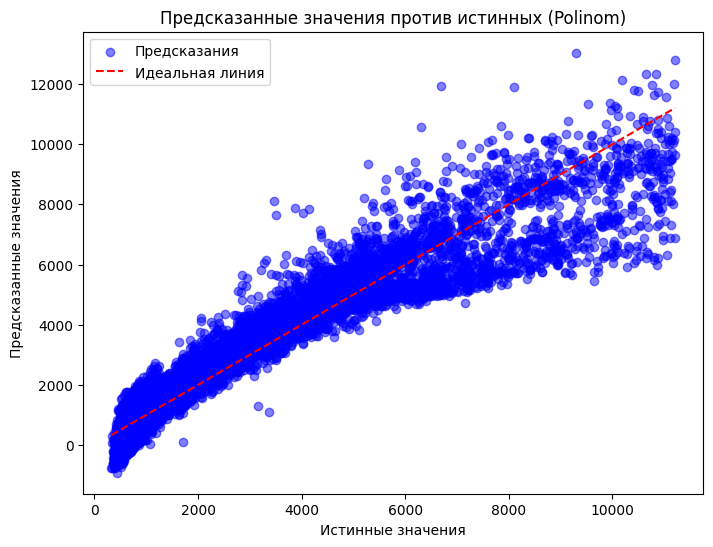

In [37]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lasso_grid, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

In [9]:
random_search = RandomizedSearchCV(
        Lasso(),
        param_distributions= alpha_values,
        n_iter=20,  # Количество случайных комбинаций для проверки
        random_state=42,  # Для воспроизводимости результатов
    ).fit(X_train, y_train)
y_pred_lasso_rand = random_search.predict(X_test)
this_dict_errors = dict_errors(y_pred_lasso_rand, y_test)
add_err_to_dataframe(table_all_metrics, 'Lasso_random', this_dict_errors)

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.002e+10, tolerance: 2.083e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.016e+10, tolerance: 2.106e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

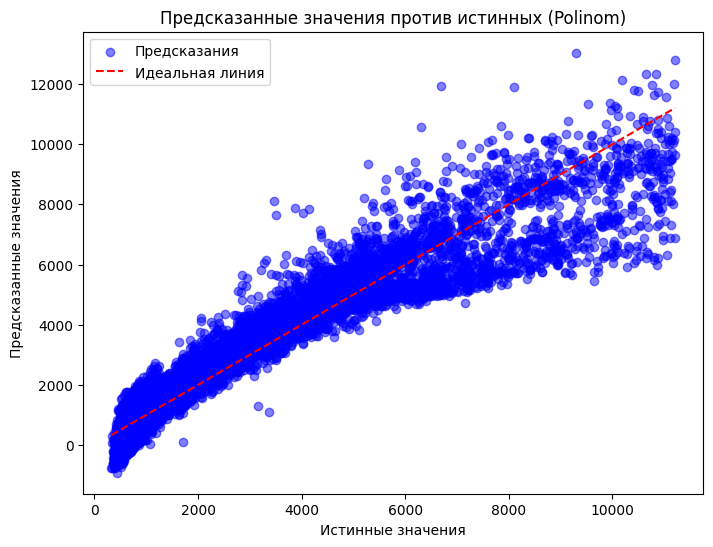

In [36]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lasso_rand, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

In [10]:
# Функция для оптимизации гиперпараметров с использованием Optuna
def objective_lasso(trial):
    # Задаем гиперпараметры для поиска
    alpha = trial.suggest_float('alpha', 1e-3, 1e2, log=True)  # логарифмический диапазон
    lasso = Lasso(alpha=alpha)
    
    # Вычисляем среднюю ошибку на кросс-валидации
    score = cross_val_score(lasso, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return score.mean()

In [11]:
study = optuna.create_study(direction='maximize') 
study.optimize(objective_lasso, n_trials=20)  
    
# Получаем лучшие параметры и обучаем модель
best_params = study.best_params
lasso = Lasso(**best_params)
lasso.fit(X_train, y_train)
y_pred_lasso_optuna = lasso.predict(X_test)
this_dict_errors = dict_errors(y_pred_lasso_optuna, y_test)
add_err_to_dataframe(table_all_metrics, 'Lasso_optuna', this_dict_errors)


[I 2025-03-28 01:37:25,370] A new study created in memory with name: no-name-a63f8c20-ce35-40ac-a1a4-fd0d7ec6741d
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.820e+09, tolerance: 2.083e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.985e+09, tolerance: 2.106e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: Con

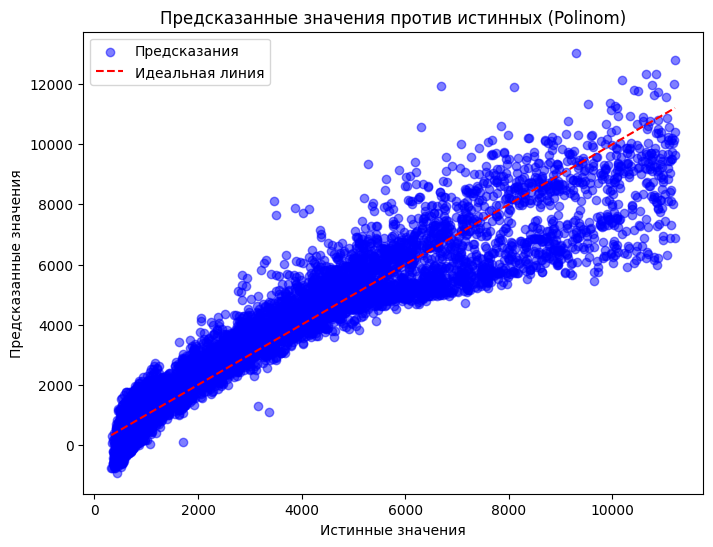

In [35]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lasso_optuna, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

# L2 (Ridge)

In [12]:
alpha_values = {'alpha': np.linspace(0.1, 1, 20)}
grid_search = GridSearchCV(Ridge(), alpha_values).fit(X_train, y_train)
y_pred_ridge_grid = grid_search.predict(X_test)
this_dict_errors = dict_errors(y_pred_ridge_grid, y_test)
add_err_to_dataframe(table_all_metrics, 'Ridge_grid', this_dict_errors)

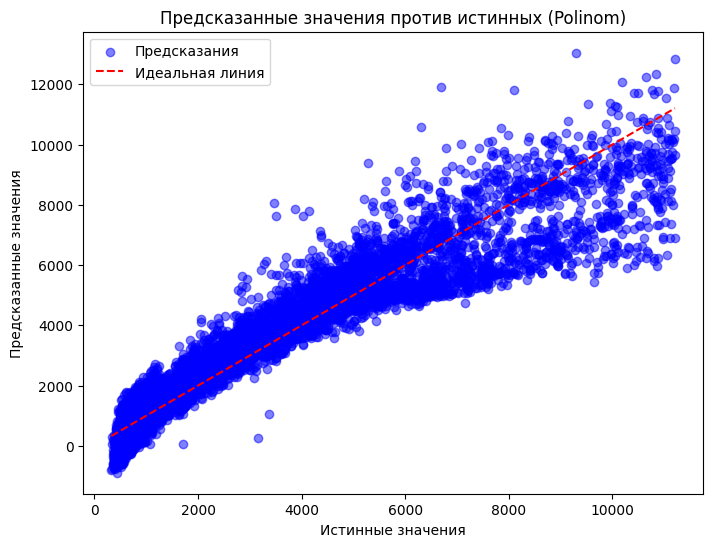

In [34]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge_grid, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

In [13]:
random_search = RandomizedSearchCV(
        Ridge(),
        param_distributions= alpha_values,
        n_iter=20,  # Количество случайных комбинаций для проверки
        random_state=42,  # Для воспроизводимости результатов
    ).fit(X_train, y_train)
y_pred_ridge_rand = random_search.predict(X_test)
this_dict_errors = dict_errors(y_pred_ridge_rand, y_test)
add_err_to_dataframe(table_all_metrics, 'Ridge_random', this_dict_errors)

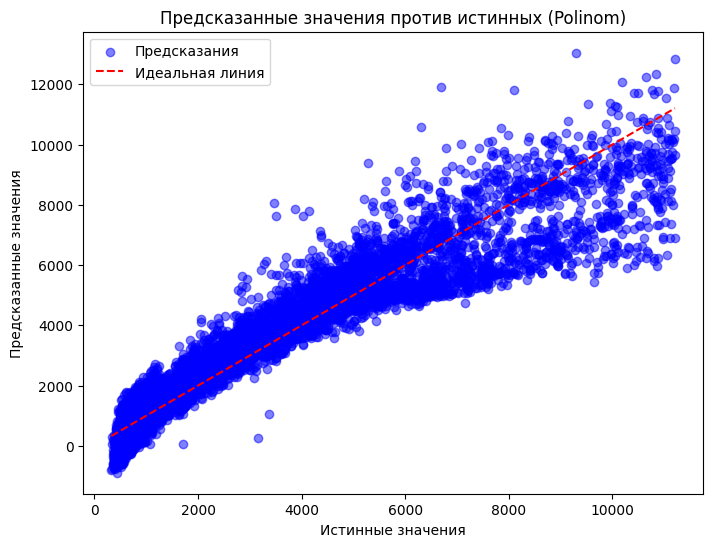

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge_rand, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

In [14]:
# Функция для оптимизации гиперпараметров с использованием Optuna
def objective_ridge(trial):
    # Задаем гиперпараметры для поиска
    alpha = trial.suggest_float('alpha', 1e-3, 1e2, log=True)  # логарифмический диапазон
    ridge = Ridge(alpha=alpha)
    
    # Вычисляем среднюю ошибку на кросс-валидации
    score = cross_val_score(ridge, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return score.mean()

In [15]:
study = optuna.create_study(direction='maximize') 
study.optimize(objective_ridge, n_trials=20)  
    
# Получаем лучшие параметры и обучаем модель
best_params = study.best_params
ridge = Ridge(**best_params)
ridge.fit(X_train, y_train)
y_pred_ridge_optuna = ridge.predict(X_test)
this_dict_errors = dict_errors(y_pred_ridge_optuna, y_test)
add_err_to_dataframe(table_all_metrics, 'ridge_optuna', this_dict_errors)

[I 2025-03-28 01:39:19,489] A new study created in memory with name: no-name-a72aefe4-595f-4c3d-87c6-0fc75215293c
[I 2025-03-28 01:39:19,519] Trial 0 finished with value: -673764.317479501 and parameters: {'alpha': 0.21192501855843018}. Best is trial 0 with value: -673764.317479501.
[I 2025-03-28 01:39:19,547] Trial 1 finished with value: -673764.4799505377 and parameters: {'alpha': 26.03871884596939}. Best is trial 0 with value: -673764.317479501.
[I 2025-03-28 01:39:19,573] Trial 2 finished with value: -673764.3170670553 and parameters: {'alpha': 0.11662209859752624}. Best is trial 2 with value: -673764.3170670553.
[I 2025-03-28 01:39:19,600] Trial 3 finished with value: -673764.3165688156 and parameters: {'alpha': 0.0010682432010183927}. Best is trial 3 with value: -673764.3165688156.
[I 2025-03-28 01:39:19,628] Trial 4 finished with value: -673764.3170563385 and parameters: {'alpha': 0.11414163353598057}. Best is trial 3 with value: -673764.3165688156.
[I 2025-03-28 01:39:19,655] T

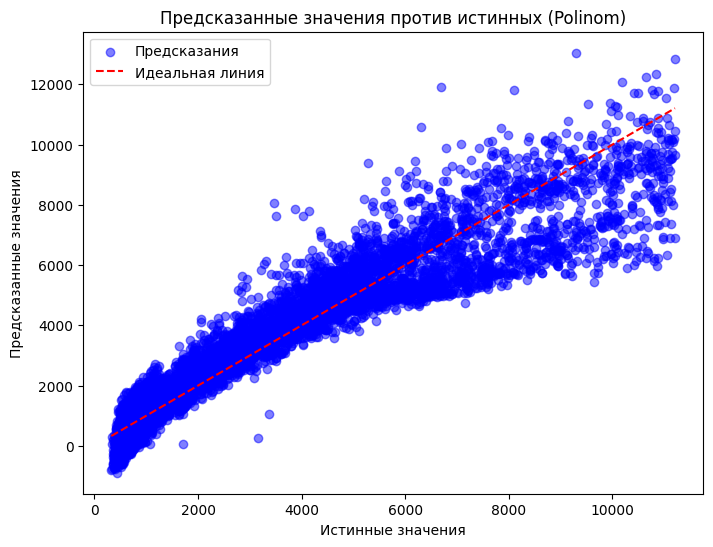

In [32]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge_optuna, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

# Elastic Net (линейная регрессия с двумя регуляризаторами)

In [16]:
alpha_values = {'alpha': np.linspace(0.1, 1, 20)}
grid_search = GridSearchCV(ElasticNet(), alpha_values).fit(X_train, y_train)
y_pred_elastic_grid = grid_search.predict(X_test)
this_dict_errors = dict_errors(y_pred_elastic_grid, y_test)
add_err_to_dataframe(table_all_metrics, 'Elastic_grid', this_dict_errors)

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.014e+10, tolerance: 2.083e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.028e+10, tolerance: 2.106e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

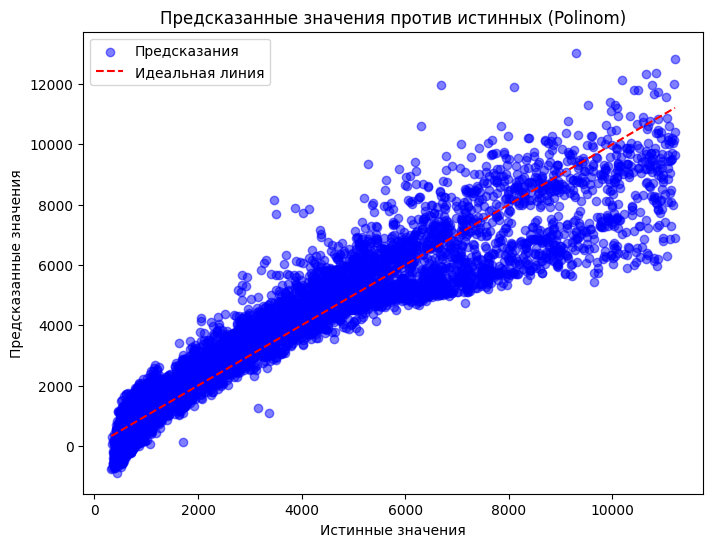

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_elastic_grid, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

In [17]:
random_search = RandomizedSearchCV(
        ElasticNet(),
        param_distributions= alpha_values,
        n_iter=20,  # Количество случайных комбинаций для проверки
        random_state=42,  # Для воспроизводимости результатов
    ).fit(X_train, y_train)
y_pred_elastic_rand = random_search.predict(X_test)
this_dict_errors = dict_errors(y_pred_elastic_rand, y_test)
add_err_to_dataframe(table_all_metrics, 'Elastic_random', this_dict_errors)

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.014e+10, tolerance: 2.083e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.028e+10, tolerance: 2.106e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

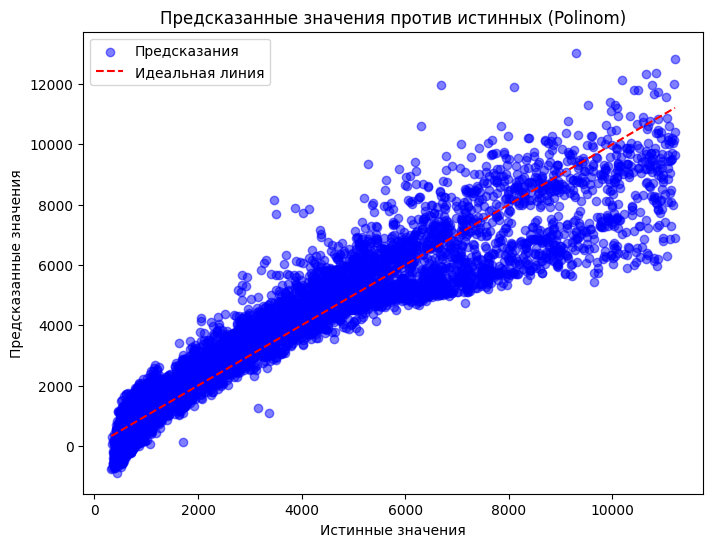

In [30]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_elastic_rand, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

In [18]:
# Функция для оптимизации гиперпараметров с использованием Optuna
def objective_elastic(trial):
    # Задаем гиперпараметры для поиска
    alpha = trial.suggest_float('alpha', 1e-3, 1e2, log=True)  # логарифмический диапазон
    elastic = ElasticNet(alpha=alpha)
    
    # Вычисляем среднюю ошибку на кросс-валидации
    score = cross_val_score(elastic, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return score.mean()

In [19]:
study = optuna.create_study(direction='maximize') 
study.optimize(objective_elastic, n_trials=20)  
    
# Получаем лучшие параметры и обучаем модель
best_params = study.best_params
elastic = Ridge(**best_params)
elastic.fit(X_train, y_train)
y_pred_elastic_optuna = elastic.predict(X_test)
this_dict_errors = dict_errors(y_pred_elastic_optuna, y_test)
add_err_to_dataframe(table_all_metrics, 'Elastic_optuna', this_dict_errors)

[I 2025-03-28 01:43:01,854] A new study created in memory with name: no-name-48116ad6-f1cf-4726-8f51-e4dc134fd76d
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.095e+10, tolerance: 2.083e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.124e+10, tolerance: 2.106e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: Con

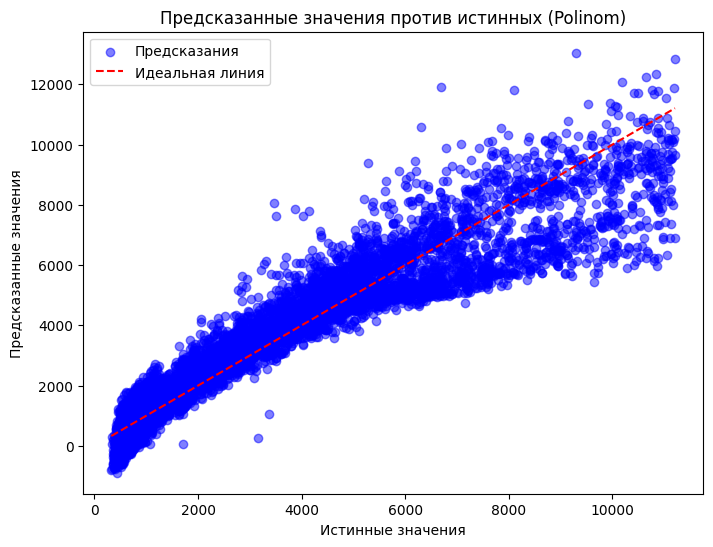

In [29]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_elastic_optuna, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

# Полиномиальная

In [20]:
poly = PolynomialFeatures(degree=2)  # degree=2 означает квадратичные признаки
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Обучение модели
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# Предсказания на тестовой выборке
y_pred_poly = poly_model.predict(X_test_poly)

this_dict_errors = dict_errors(y_pred_poly, y_test)
add_err_to_dataframe(table_all_metrics, 'Polinom', this_dict_errors)

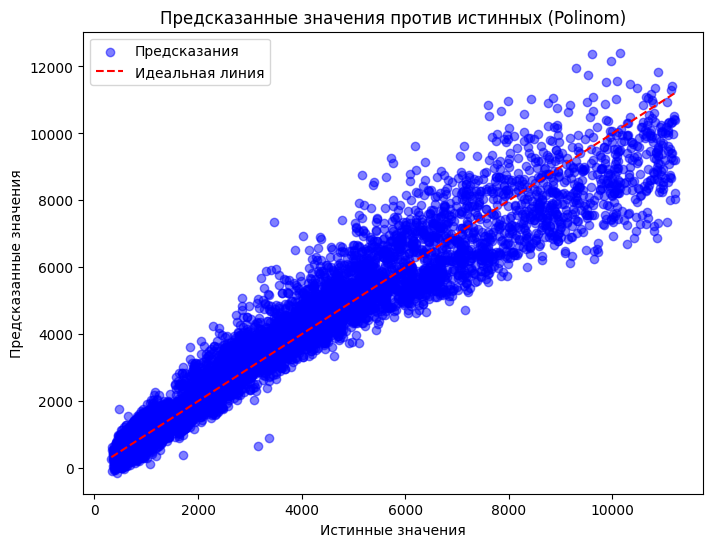

In [28]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_poly, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

# Пайплайн

In [21]:
# Создание пайплайна
pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2)),  # Полиномиальные признаки степени 2
    ('linear_regression', LinearRegression())                            # Линейная регрессия
])

# Обучение пайплайна
pipeline.fit(X_train, y_train)

# Предсказание и оценка
y_pred_pipeline = pipeline.predict(X_test)

this_dict_errors = dict_errors(y_pred_pipeline, y_test)
add_err_to_dataframe(table_all_metrics, 'Pipeline', this_dict_errors)

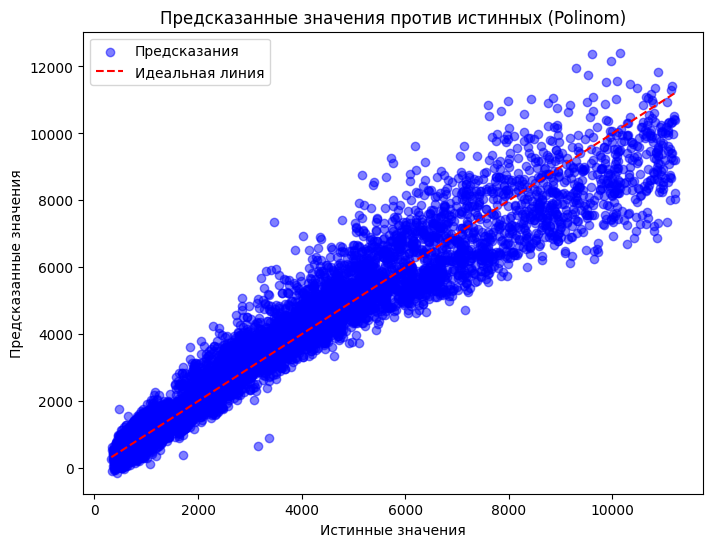

In [27]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_pipeline, alpha=0.5, color='blue', label='Предсказания')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Идеальная линия')
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Предсказанные значения против истинных (Polinom)")
plt.legend()
plt.show()

In [22]:
table_all_metrics

,Model,MAE,MSE,RMSE,MAPE,R^2
0,Linear_regression,561.439770,670719.300007,818.974542,0.551788,0.903073
1,Lasso_grid,561.415766,671184.846561,819.258718,0.552119,0.903006
2,Lasso_random,561.415766,671184.846561,819.258718,0.552119,0.903006
3,Lasso_optuna,561.411503,671185.439673,819.259080,0.552111,0.903005
4,Ridge_grid,561.438125,670719.326925,818.974558,0.551785,0.903073
5,Ridge_random,561.438125,670719.326925,818.974558,0.551785,0.903073
6,ridge_optuna,561.439769,670719.300031,818.974542,0.551788,0.903073
7,Elastic_grid,558.538590,671345.319299,819.356650,0.547290,0.902982
8,Elastic_random,558.538590,671345.319299,819.356650,0.547290,0.902982
9,Elastic_optuna,561.439751,670719.300324,818.974542,0.551788,0.903073


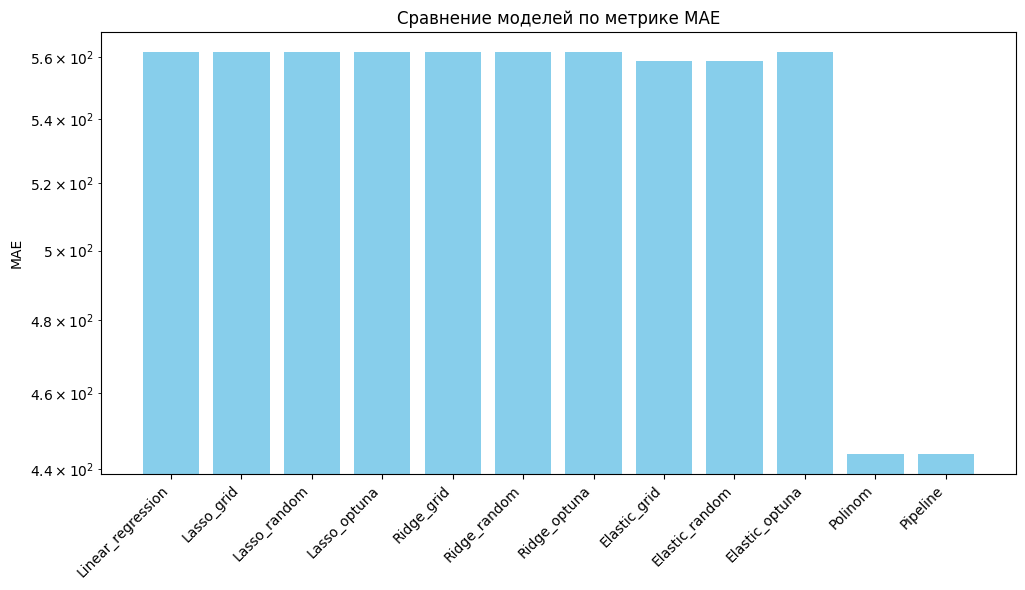

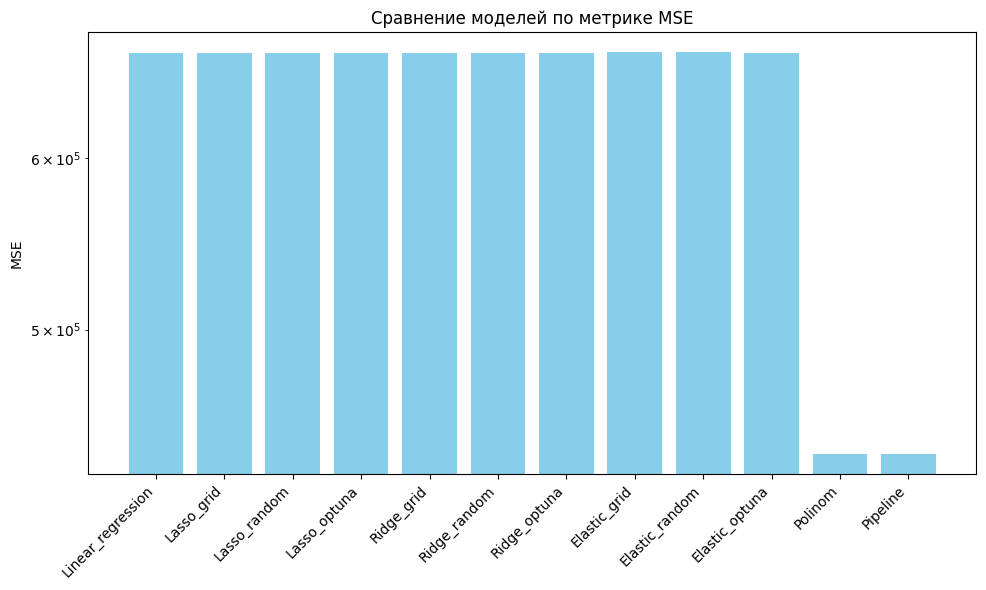

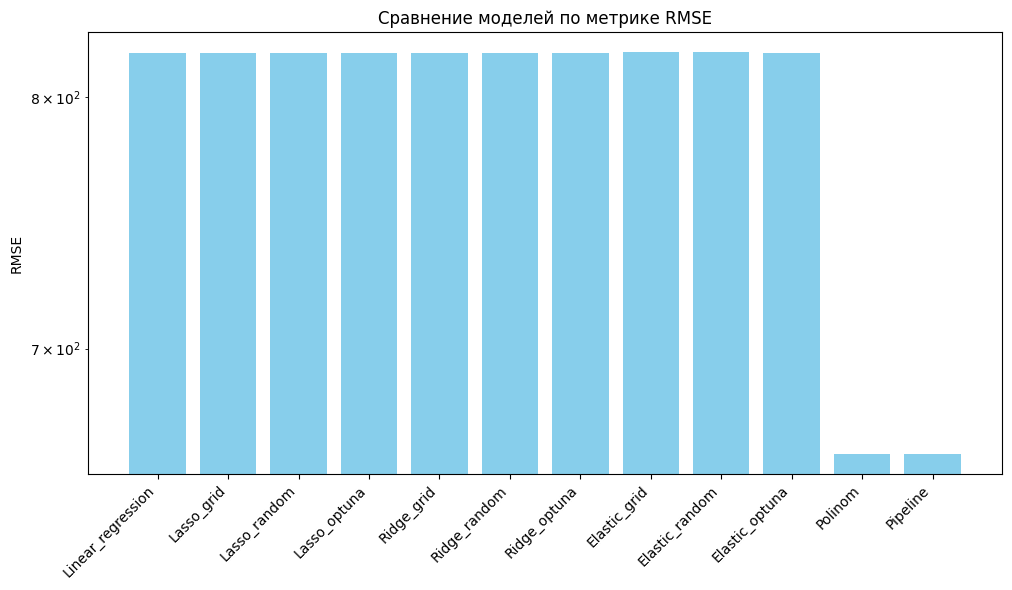

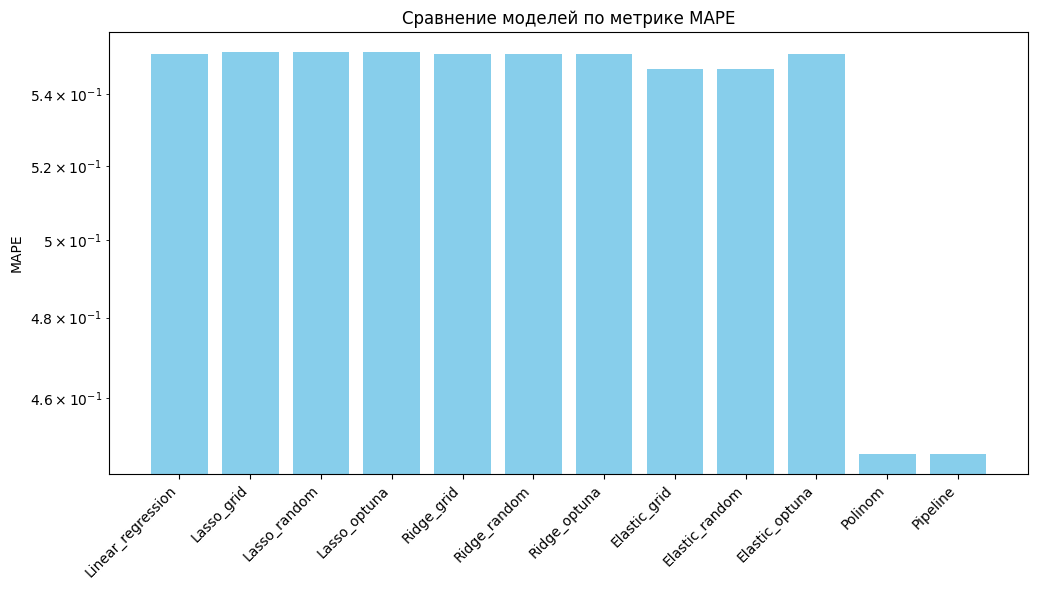

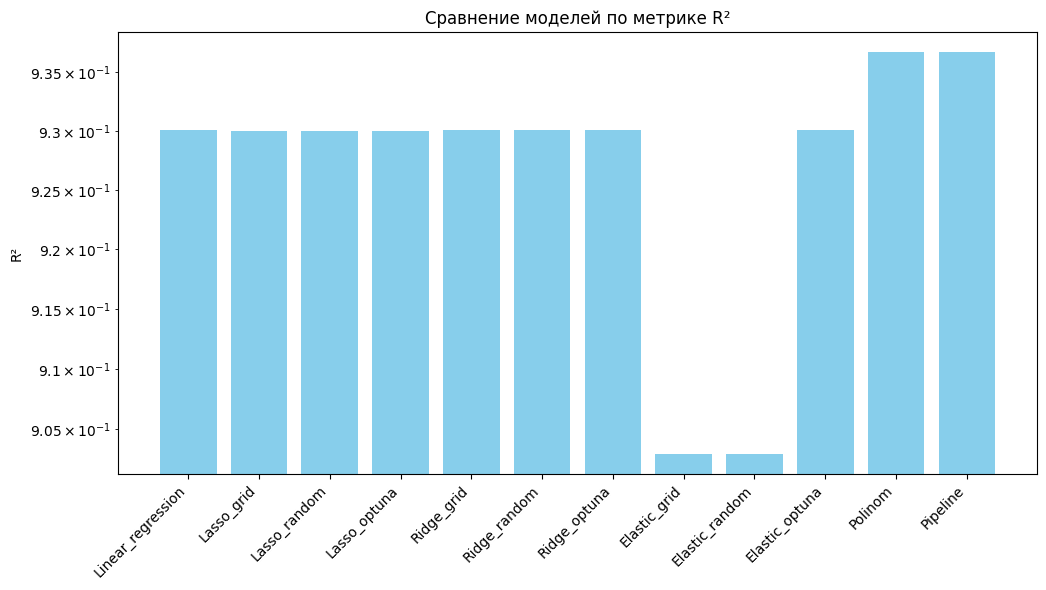

In [26]:
# Данные из таблицы
models = [
    "Linear_regression", "Lasso_grid", "Lasso_random", "Lasso_optuna", "Ridge_grid",
    "Ridge_random", "Ridge_optuna", "Elastic_grid", "Elastic_random", "Elastic_optuna",
    "Polinom", "Pipeline"
]
mae = [561.439770, 561.415766, 561.415766, 561.411503, 561.438125, 561.438125, 561.439769, 558.538590, 558.538590, 561.439751, 443.993762, 443.993762]
mse = [670719.300007, 671184.846561, 671184.846561, 671185.439673, 670719.326925, 670719.326925, 670719.300031, 671345.319299, 671345.319299, 670719.300324, 438197.795584, 438197.795584]
rmse = [818.974542, 819.258718, 819.258718, 819.259080, 818.974558, 818.974558, 818.974542, 819.356650, 819.356650, 818.974542, 661.965101, 661.965101]
mape = [0.551788, 0.552119, 0.552119, 0.552111, 0.551785, 0.551785, 0.551788, 0.547290, 0.547290, 0.551788, 0.446734, 0.446734]
r2 = [0.930073, 0.930006, 0.930006, 0.930005, 0.930073, 0.930073, 0.930073, 0.902982, 0.902982, 0.930073, 0.936675, 0.936675]

# Построение графиков
metrics = {"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape, "R²": r2}

for metric_name, metric_values in metrics.items():
    plt.figure(figsize=(10, 6))
    plt.bar(models, metric_values, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Сравнение моделей по метрике {metric_name}")
    plt.ylabel(metric_name)
    plt.tight_layout()
    plt.yscale('log')
    plt.show()

# Вывод: Лучшая модель регрессии

После анализа метрик всех моделей регрессии лучшей моделью является **Polinom** (или эквивалентная ей Pipeline, так как их метрики идентичны). 

## Обоснование выбора:
1. **Минимальные ошибки**:
   - **MAE**: 443.993762 — самое низкое значение среди всех моделей.
   - **MSE**: 438197.795584 — также минимальное значение.
   - **RMSE**: 661.965101 — лучшее значение.
   - **MAPE**: 0.446734 — наименьший процент ошибки.
   Эти метрики показывают, что Polinom делает наименьшие ошибки в предсказаниях.

2. **Максимальный R²**:
   - **R²**: 0.936675 — самый высокий показатель. Это говорит о том, что Polinom лучше всего объясняет вариацию целевой переменной.

3. **Сравнение с другими моделями**:
   - Модели Linear_regression, Lasso (все варианты), Ridge (все варианты) и Elastic_optuna показывают близкие результаты с R² около 0.9300–0.93007, но их ошибки выше, чем у Polinom.
   - Elastic_grid и Elastic_random имеют худшие показатели (например, R² = 0.902982), что делает их наименее предпочтительными.
   - Pipeline имеет идентичные метрики с Polinom, что может указывать на то, что это одна и та же модель или её вариация.

## Итог:
**Polinom** (или Pipeline) является лучшей моделью, так как она демонстрирует наименьшие ошибки по всем метрикам (MAE, MSE, RMSE, MAPE) и наивысший R², что свидетельствует о её превосходной предсказательной способности. Если требуется дальнейшая оптимизация, можно рассмотреть добавление новых признаков или настройку гиперпараметров, но текущие результаты уже впечатляющие.